# **Chatbot With Neural Network**

<b>Chatbot</b> merupakan bagian dari Natural Language Processing yang digunakan untuk percakapan dengan pengguna melalui teks dan ucapan. Pada praktik hari ini kita akan membuat sebuah chat otomatis atau chatbot tentang program Kampus Merdeka dari Kementerian Pendidikan Kebudayaan Riset dan Teknologi (KEMENDIKBUDRISTEK). 

Dalam tahapan Chatbot ini ada tahapan yang harus kita perhatikan yaitu,

1. Import Library
2. Load Dataset
3. Preprocessing Data
4. Input Length, Output Length and Vocabulary
5. Neural Network Model
6. Model Analysis
7. Testing
8. Save Model

Dalam proyek ini, kita akan membuat chatbot tentang program Kampus Merdeka!

Sumber code: [Medium - Going Merry With Tensorflow 2.0](https://medium.com/analytics-vidhya/chatbot-with-tensorflow-2-0-going-merry-2f79284a6104)

# **Load Google Drive**

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

## **Instalasi Library Pengenal Suara**

In [5]:
!pip -q install speechrecognition

     |████████████████████████████████| 32.8 MB 2.0 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 


In [6]:
!pip -q install gtts

     |████████████████████████████████| 96 kB 3.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [7]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Import Library**

Tahapan pertama sebelum melakukan eksplorasi dan praproses pada data adalah memasukan library yang akan digunakan untuk menganalisa dataset dengan menggunakan metode Deep Learning seperti Neural Network dalam pengolahan teks, Chatbot dll. Library yang saya gunakan yaitu NumPy untuk komputasi matematika, Matplotlib untuk visualisasi model data, Natural Language Toolkit atau NLTK untuk pengolahan teks, Pandas untuk membaca data, serta Tensorflow untuk model pada data menggunakan algoritma LSTM dan Jaringan Syaraf Tiruan (Neural Network).

In [8]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

## **Download NLTK Package**

In [9]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# **Load Dataset Json**

Setelah import library, tahapan selanjutnya adalah me-load dataset yang telah disediakan. Dataset yang digunakan berupa format **.json** yang sangat cocok untuk membuat model Chatbot. Data Json merupakan data yang termasuk dalam *semi structured* yang dimana data ini menampung beberapa bagian data seperti **tag**, **pattern**, **context**, dan **response**. Data yang dipakai dalam proyek ini menggunakan dataset manual yang diciptakan oleh student Kampus Merdeka Batch 2 tentang <b>Chatbot Sistem Rekomendasi Kampus Merdeka</b>. [Github](https://github.com/mahmudwhd/WebKadekBot)

In [10]:
# Importing the dataset
with open('/content/data.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [11]:
data

,patterns,tags
0,Halo,greeting
1,Hallo,greeting
2,Hai,greeting
3,Hei,greeting
4,Woy,greeting
...,...,...
966,Penyebab panic attac kambuh?,panic attack
967,Apa saja gejala panic attack??,panic attack
968,Gejala serangan panik?,panic attack
969,tanda tanda panic attack?,panic attack


In [12]:
data.head() # Cetak data baris pertama sampai baris kelima

,patterns,tags
0,Halo,greeting
1,Hallo,greeting
2,Hai,greeting
3,Hei,greeting
4,Woy,greeting


In [13]:
data.tail() # Cetak data baris ke-70 sampai baris akhir

,patterns,tags
966,Penyebab panic attac kambuh?,panic attack
967,Apa saja gejala panic attack??,panic attack
968,Gejala serangan panik?,panic attack
969,tanda tanda panic attack?,panic attack
970,Sebutkan gelaja panic attack?,panic attack


Data yang telah kita miliki dalam format JSON yang dapat digunakan melalui pandas dengan cara konversi. Data JSON yang saya miliki didapat dengan cara manual dengan mengambil beberapa referensi website tentang program Kampus Merdeka.

# **Preprocessing The Data**

Setelah kita meload data dan mengonversi data json menjadi dataframe. Tahapan selanjutnya adalah praproses pada dataset yang kita gunakan saat ini yaitu dengan cara:

1.   Remove Punctuations (Menghapus Punktuasi)
2.   Lematization (Lematisasi)
3.   Tokenization (Tokenisasi)
4.   Apply Padding (Padding)
5.   Encoding the Outputs (Konversi Keluaran Enkoding)

In [14]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
data

,patterns,tags
0,halo,greeting
1,hallo,greeting
2,hai,greeting
3,hei,greeting
4,woy,greeting
...,...,...
966,penyebab panic attac kambuh,panic attack
967,apa saja gejala panic attack,panic attack
968,gejala serangan panik,panic attack
969,tanda tanda panic attack,panic attack


In [15]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

485 unique lemmatized words ['(', ')', ',', '.', 'ada', 'adalah', 'adhd', 'adiksi', 'afternoon', 'agar', 'aja', 'akan', 'akhir-akhir', 'akibat', 'akibatnya', 'aktif', 'alami', 'alasan', 'alzheimer', 'amnesia', 'anak', 'antara', 'anxiety', 'apa', 'apakah', 'apotik', 'artinya', 'assalamualaikum', 'atau', 'attac', 'attack', 'attention', 'autis', 'azzahra', 'bagai', 'bagaimana', 'bagian', 'bahaya', 'bai', 'banyak', 'bata', 'bayi', 'beberapa', 'bedanya', 'benar', 'berapa', 'berarti', 'berat', 'berbahaya', 'berbicara', 'bergetar', 'berlebihan', 'berobat', 'bertanya', 'bertingkah', 'berubah', 'biaya', 'bipolar', 'bisa', 'bisakah', 'boleh', 'bro', 'bunuh', 'butuh', 'bye', 'byee', 'cara', 'cegah', 'cemas', 'cepat', 'cerdas', 'cinta', 'ciri', 'ciri-ciri', 'contoh', 'curhat', 'dadah', 'dah', 'dalam', 'dampak', 'dan', 'dapat', 'dari', 'deficit', 'definisi', 'demam', 'demensia', 'dengan', 'depan', 'depresi', 'dewasa', 'di', 'dialami', 'dibutuhkan', 'dicegah', 'didiagnosa', 'digunakan', 'dihilangkan

In [16]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

267 classes [' Gangguan Kepribadian', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', 'Apa Perbedaan depresi dan gila?', 'Apa ciri ciri stres?', 'Apa contoh stress?', 'Apa nama obat depresi di apotik?', 'Apa obat penghilang stres?', 'Apa perbedaan antara depresi dan stres?', 'Apa perbedaan gangguan jiwa dan gangguan mental?', 'Apa sumber stres terbesar?', 'Apa yang menyebabkan stres?', 'Apa yang terjadi jika stres?', 'Apakah depresi termasuk gangguan jiwa?', 'Apakah menyakiti diri sendiri itu dosa?', 'Apakah orang depresi bisa tertawa?', 'Apakah overthinking termasuk gangguan mental?', 'Apakah semua orang pernah stres?', 'Apakah stres dapat menjadi depresi?', 'Attention Deficit Hyperactivity Disorder (ADHD)', 'Bagaimana cara agar tidak terlalu memikirkan masalah?', 'Bagaimana cara keluar d

In [17]:
# documents = combination between patterns and intents
print (len(documents), "documents")

4081 documents


In [18]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[307],
 [220],
 [308],
 [309],
 [310],
 [311],
 [312],
 [313],
 [314],
 [315],
 [316],
 [317],
 [318],
 [319],
 [320],
 [321],
 [322],
 [323],
 [324],
 [325],
 [326],
 [221],
 [327],
 [328, 221],
 [329, 330],
 [191, 331],
 [332],
 [333, 222],
 [334],
 [335, 222],
 [223, 224],
 [336],
 [223, 224, 225],
 [220, 226, 337, 338],
 [226],
 [80, 11, 339, 1, 19],
 [1, 3, 11, 80, 340],
 [4, 80, 11, 227, 34],
 [16, 10, 80, 227, 34],
 [1, 136, 228, 14, 20],
 [1, 5, 14, 88, 20],
 [192, 14, 88, 20],
 [229, 20, 341],
 [229, 14, 20],
 [14, 20, 46, 193],
 [10, 342, 89, 94, 20, 1],
 [161, 89, 62, 14, 20],
 [28, 343, 81, 104],
 [28, 344, 81, 104],
 [28, 345, 81, 104],
 [90, 88, 20, 105, 346],
 [230, 46, 347, 1],
 [40, 230, 137, 231, 21, 104],
 [28, 119, 89, 162, 81, 104],
 [90, 104, 231],
 [14, 20, 4, 65],
 [1, 41, 35, 30, 106],
 [16, 10, 348, 21, 35],
 [1, 232, 75, 35, 50, 349],
 [75, 44, 35],
 [66, 75, 44, 35],
 [1, 41, 26, 58, 30, 26, 20],
 [163, 89, 46, 350, 81, 104],
 [20, 3, 194, 5, 82, 1],
 [1, 5

In [19]:
# Apply padding 
x_train = pad_sequences(train)

# Encoding the outputs 
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [20]:
print(x_train) # Padding Sequences

[[  0   0   0 ...   0   0 307]
 [  0   0   0 ...   0   0 220]
 [  0   0   0 ...   0   0 308]
 ...
 [  0   0   0 ...  13 306 302]
 [  0   0   0 ... 103  61  70]
 [  0   0   0 ... 482  61  70]]


In [21]:
print(y_train) #Label Encodings

[158 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158
 158 157 157 157 157 157 157 157 157 157 260 260 260 260 260 250 250 167
 167 167 167 133 133 133 133 133  94  56  56  54  54  54  83  96  78  55
  84  93  32  50  35  35  35  38  74  86  86  86  45  45  76  49 174 174
 115 115 115 115 115 125 125 125 125 125 125 125 125 125 125 125 125 125
 255 255 255 255 255  40  40  41  41  41  33  33  33  36  36  36  51  51
  51  51  39  39  39  37  37  73  73  34  34  58  58  85  85  46  46  47
  47  77  77  80  80  60  60  59  59  59  59  59 265 265 101  42  44  79
  43  99  99  99  99  99  87  65  65  65  65  65  64  64  64  64  64  67
  67  67  67  67  66  66  66  66  66  88  88  88  88  88   0   0   0   0
   0  98  98  98  98  98  97  97  97  97  97  62  62  62  62  62  61  61
  61  61  61 100 100 100 100 100 100  81  81  81  81  81  81  81  48  48
  48  48  48  48  48 248 248 248  91  91  91  91 145 145 262 262 261 261
 245 245 168 168  92  92  92  92  92  92  92  95  9

Tokenizer pada Tensorflow memberikan token unik untuk setiap kata yang berbeda. Dan juga padding dilakukan untuk mendapatkan semua data dengan panjang yang sama sehingga dapat mengirimkannya ke lapisan atau layer RNN. variabel target juga dikodekan menjadi nilai desimal.

# **Input Length, Output Length and Vocabulary**



In [22]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

23


In [23]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  482
output length:  267


**Input length** dan **output length** terlihat sangat jelas hasilnya. Mereka adalah untuk bentuk input dan bentuk output dari jaringan syaraf pada algoritma Neural Network.

**Vocabulary Size** adalah untuk lapisan penyematan untuk membuat representasi vektor unik untuk setiap kata.

# **Save Model Words & Classes**

In [24]:
pickle.dump(words, open('/content/texts.pkl','wb'))
pickle.dump(classes, open('/content/labels.pkl','wb'))

# **Neural Network Model**

Jaringan syaraf yang terdiri dari lapisan embedding yang merupakan salah satu hal yang paling kuat di bidang pemrosesan bahasa alami atau NLP. output atau keluaran dari lapisan embedding adalah input dari lapisan berulang (*recurrent*) dengan LSTM gate. Kemudian, output diratakan dan lapisan Dense digunakan dengan fungsi aktivasi softmax.

Bagian utama adalah lapisan embedding yang memberikan vektor yang sesuai untuk setiap kata dalam dataset.

In [27]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

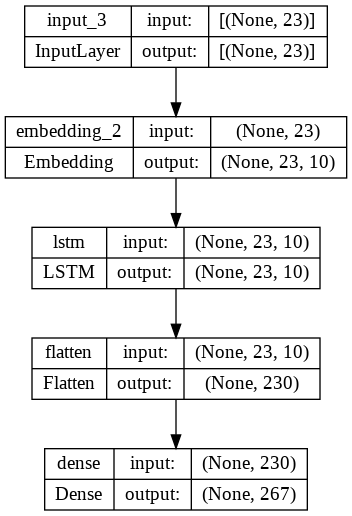

In [28]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='/content/chatbot.png', show_shapes=True, show_layer_names=True)

In [29]:
model.summary() # Menampilkan Parameter Model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 23)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 23, 10)            4830      
                                                                 
 lstm (LSTM)                 (None, 23, 10)            840       
                                                                 
 flatten (Flatten)           (None, 230)               0         
                                                                 
 dense (Dense)               (None, 267)               61677     
                                                                 
Total params: 67,347
Trainable params: 67,347
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Training the model (Latih Model Data)
train = model.fit(x_train, y_train, epochs=400)

Epoch 1/400
31/31 [==============================] - 4s 16ms/step - loss: 5.5760 - accuracy: 0.0082
Epoch 2/400
31/31 [==============================] - 1s 17ms/step - loss: 5.4451 - accuracy: 0.0206
Epoch 3/400
31/31 [==============================] - 1s 16ms/step - loss: 5.3361 - accuracy: 0.0165
Epoch 4/400
31/31 [==============================] - 1s 17ms/step - loss: 5.3003 - accuracy: 0.0206
Epoch 5/400
31/31 [==============================] - 0s 16ms/step - loss: 5.2765 - accuracy: 0.0206
Epoch 6/400
31/31 [==============================] - 1s 16ms/step - loss: 5.2413 - accuracy: 0.0227
Epoch 7/400
31/31 [==============================] - 0s 16ms/step - loss: 5.1916 - accuracy: 0.0340
Epoch 8/400
31/31 [==============================] - 1s 17ms/step - loss: 5.1270 - accuracy: 0.0330
Epoch 9/400
31/31 [==============================] - 1s 17ms/step - loss: 5.0371 - accuracy: 0.0402
Epoch 10/400
31/31 [==============================] - 1s 17ms/step - loss: 4.9199 - accuracy: 0.0505

# **Model Analysis**

Setelah menjalankan model fitting. Selanjutnya adalah analisa model untuk melihat hasil akurasi dari model Neural Network tersebut.

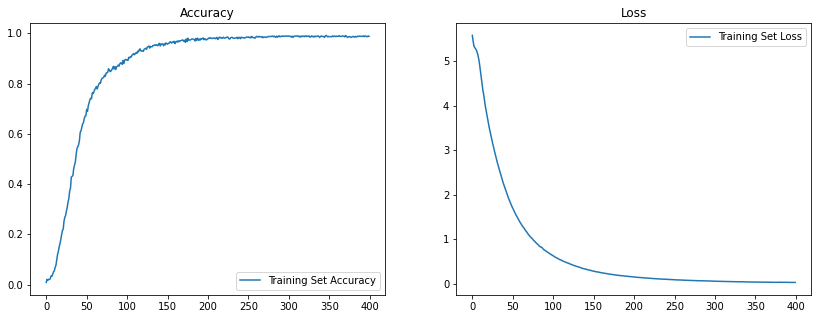

In [31]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# **Testing Chatbot Dan Tambahkan Suara Pada Chatbot**

Setelah mengetahui hasil dari akurasi dan loss pada model yang telah ditetapkan dengan algoritma Neural Network dan LSTM. Maka, tahapan selanjutnya adalah menguji atau testing pada chatbot yang telah dilatih sebelumnya dan melihat apakah sesuai atau tidak pada saat kita masukan teks kalimat pertanyaannya. 

Pada pengujian ini menggunakan metode input atau masukan sesuai dengan kalimat pertanyaan yang dimasukkan.

In [38]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('Kamu : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model 
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("KadekBot : ", random.choice(responses[response_tag]))
  tts = gTTS(random.choice(responses[response_tag]), lang='id')
  tts.save('/content/satu1.wav')
  time.sleep(0.08)
  ipd.display(ipd.Audio('/content/satu1.wav', autoplay=True))
  print("="*60 + "\n")
  if response_tag == "goodbye":
    break

Kamu : Seberapa progresif kah penyakit Alzheimer?
1/1 [==============================] - 0s 27ms/step
KadekBot :  Ini sangat bervariasi dan tergantung berbagai faktor individual, termasuk usia, tingkat kesehatan dan gaya hidup.


KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

# **Save The Model**

Setelah pengujian Chatbot telah disesuaikan dengan kalimat dan jawabannya. Maka, model chatbot bisa disimpan dengan format .h5 atau .pkl (pickle) untuk penggunaan aplikasi AI Chatbot dengan website atau sistem Android. 

In [32]:
model.save('/content/chat_model.h5')

print('Model Created Successfully!')

Model Created Successfully!
